**Install required packages**

In [1]:
!pip install mediapipe opencv-python-headless scikit-learn pandas numpy matplotlib seaborn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 7.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier ,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, classification_report,
                              confusion_matrix, ConfusionMatrixDisplay,
                              precision_score, recall_score, f1_score)
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.rcParams['figure.dpi'] = 120
sns.set_theme(style='whitegrid', palette='Set2')
print('All libraries imported successfully')

All libraries imported successfully


**Load Train & Test Splits**

In [3]:
data = joblib.load("/content/dataset_splits.pkl")

X_train = data["X_train"]
X_test  = data["X_test"]
y_train = data["y_train"]
y_test  = data["y_test"]


In [4]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (20540, 63)
y_train shape: (20540,)
X_test shape: (5135, 63)
y_test shape: (5135,)


**Models Training & Evaluation**

In [5]:
# Train Logistic Regression Model

lr_model = LogisticRegression(multi_class = 'multinomial',max_iter = 500, class_weight = 'balanced').fit(X_train, y_train)
lr_model_score = lr_model.score(X_test, y_test)
lr_model_ypred = lr_model.predict(X_test)

In [6]:
# Train Decision Tree Model

dt_model = DecisionTreeClassifier(class_weight = 'balanced').fit(X_train, y_train)
dt_model_score = dt_model.score(X_test, y_test)
dt_model_ypred = dt_model.predict(X_test)

In [7]:
# Train SVM Model

svm_model = SVC(class_weight = 'balanced').fit(X_train, y_train)
svm_model_score = svm_model.score(X_test, y_test)
svm_model_ypred = svm_model.predict(X_test)

In [8]:
# Train K-Nearest Neighbors model

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_model_score = knn_model.score(X_test, y_test)
knn_model_ypred = knn_model.predict(X_test)

In [9]:
# Train Random Forest Model

rf_model = RandomForestClassifier(class_weight ='balanced').fit(X_train, y_train)
rf_model_score = rf_model.score(X_test, y_test)
rf_model_ypred = rf_model.predict(X_test)

In [10]:
# Train XGBoost

xgb_model = XGBClassifier(n_jobs=-1).fit(X_train, y_train)
xgb_model_score = xgb_model.score(X_test, y_test)
xgb_model_ypred = xgb_model.predict(X_test)

In [11]:
def evaluate_and_save_models(y_true, models_predictions, output_path = "Models_Evaluation_Results.csv"):

    results = []
    for model_name, y_pred in models_predictions.items():
        results.append({
            "Model": model_name,
            "Accuracy": accuracy_score(y_true, y_pred),
            "F1_Score": f1_score(y_true, y_pred, average = "weighted"),
            "Precision": precision_score(y_true, y_pred, average = "weighted"),
            "Recall": recall_score(y_true, y_pred, average = "weighted")
        })

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by = "F1_Score", ascending = False).reset_index(drop = True)
    results_df = results_df.round(4)
    results_df.to_csv(output_path, index = False)

    print(f"Results saved successfully to '{output_path}'")
    return results_df

In [12]:
models_predictions = {
    "Logistic Regression": lr_model_ypred,
    "Decision Tree": dt_model_ypred,
    "SVM": svm_model_ypred,
    "KNN": knn_model_ypred,
    "Random Forest": rf_model_ypred,
    "XGBoost": xgb_model_ypred,

}

results_df = evaluate_and_save_models(y_test,
                                      models_predictions,
                                      "model_comparison_results.csv")

results_df

Results saved successfully to 'model_comparison_results.csv'


,Model,Accuracy,F1_Score,Precision,Recall
0,XGBoost,0.9834,0.9835,0.9836,0.9834
1,Random Forest,0.9778,0.9779,0.9781,0.9778
2,KNN,0.9772,0.9772,0.9774,0.9772
3,Decision Tree,0.9511,0.9512,0.9513,0.9511
4,SVM,0.9278,0.9271,0.9343,0.9278
5,Logistic Regression,0.8555,0.8551,0.8574,0.8555


XGBoost is the best performing model based on Accuracy, F1, Precision and Recall

Ensemble models (XGBoost, Random Forest) outperform simpler models (Decision Tree, SVM, Logistic Regression)

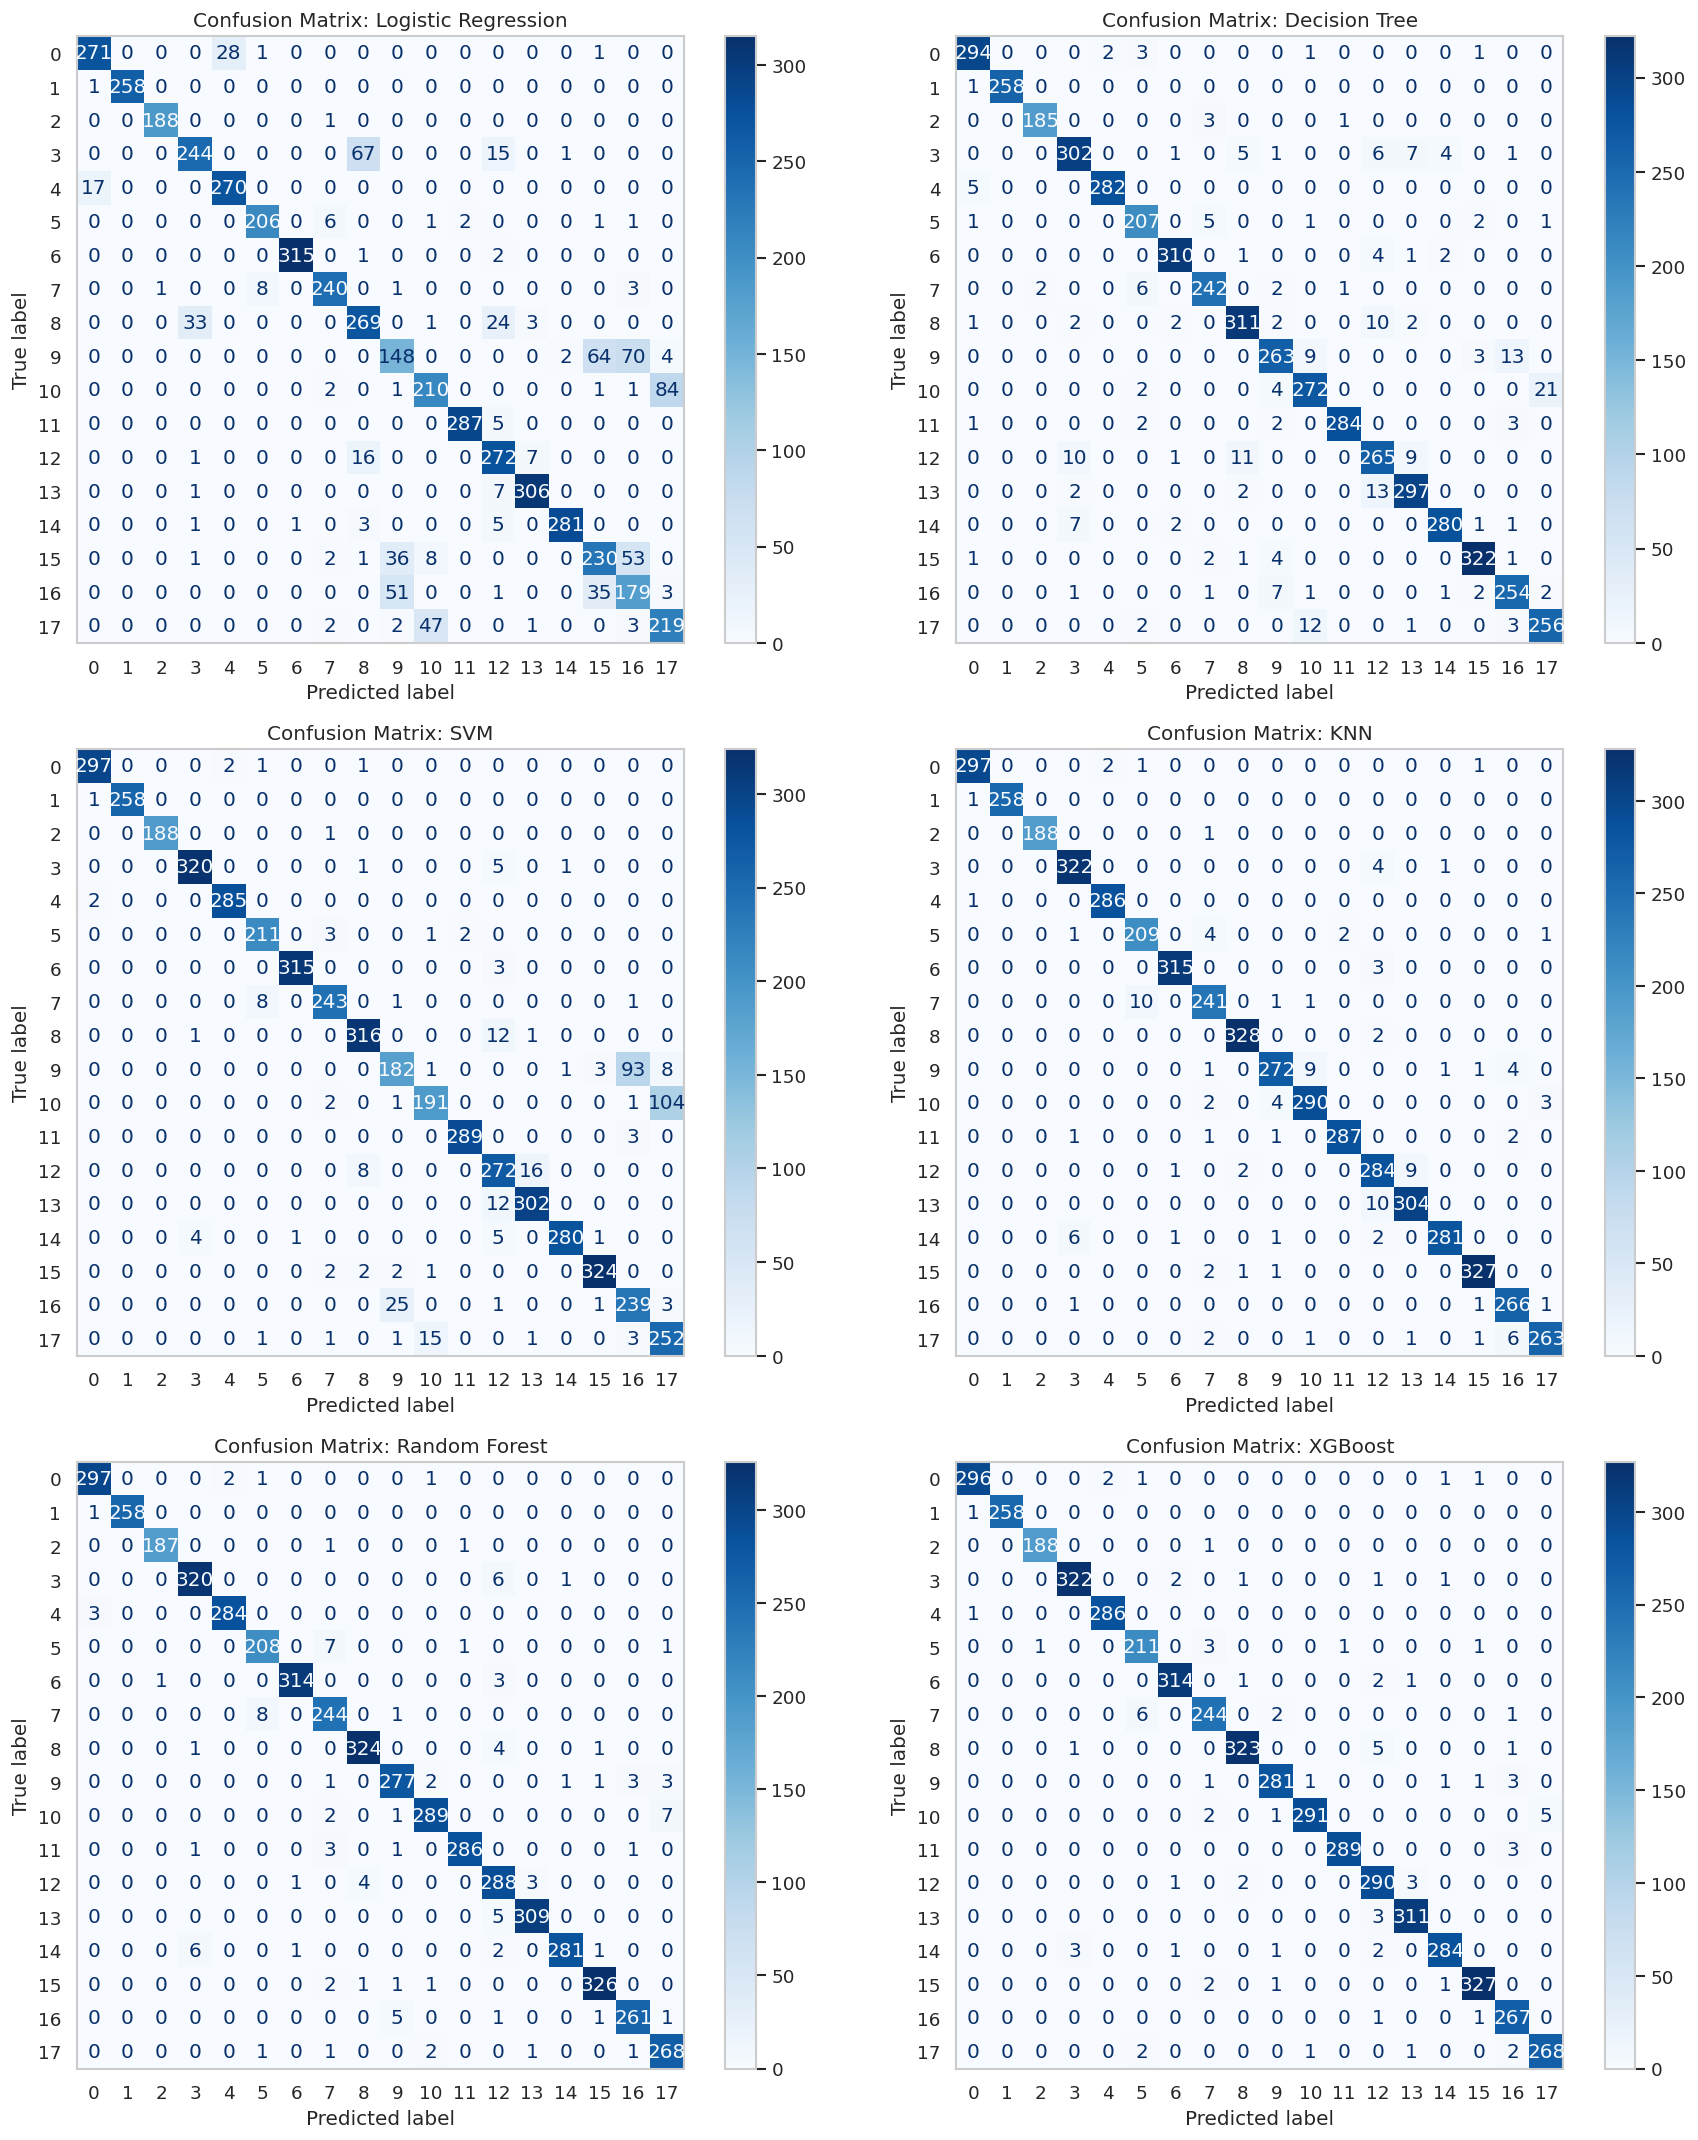

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model_names = list(models_predictions.keys())
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 18))
axes = axes.flatten()

for i, name in enumerate(model_names):
    cm = confusion_matrix(y_test, models_predictions[name])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i], cmap='Blues', values_format='d')
    axes[i].set_title(f'Confusion Matrix: {name}')
    axes[i].grid(False)

plt.tight_layout()
plt.show()

**Model Performance Evaluation (Train vs Test Comparison)**

In [14]:
def compute_metrics(models, X_train, X_test, y_train, y_test):

    metrics = {}
    for name, model in models.items():

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        metrics[name] = {
            "train_accuracy": accuracy_score(y_train, y_train_pred),
            "test_accuracy": accuracy_score(y_test, y_test_pred),

            "train_f1": f1_score(y_train, y_train_pred, average = "weighted"),
            "test_f1": f1_score(y_test, y_test_pred, average = "weighted"),

            "train_precision": precision_score(y_train, y_train_pred, average = "weighted"),
            "test_precision": precision_score(y_test, y_test_pred, average = "weighted"),

            "train_recall": recall_score(y_train, y_train_pred, average = "weighted"),
            "test_recall": recall_score(y_test, y_test_pred, average = "weighted"),
        }

    return metrics

In [15]:
def plot_metric(models, train_values, test_values, metric_name):

    x = np.arange(len(models))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, train_values, width, label="Train")
    plt.bar(x + width/2, test_values, width, label="Test")

    plt.xticks(x, models, rotation=45)
    plt.ylabel(metric_name)
    plt.title(f"{metric_name}: Train vs Test")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [16]:
def visualize_all_metrics(models, metrics):

    model_names = list(models.keys())

    # Accuracy
    plot_metric(
        model_names,
        [metrics[m]["train_accuracy"] for m in model_names],
        [metrics[m]["test_accuracy"] for m in model_names],
        "Accuracy"
    )

    # F1 Score
    plot_metric(
        model_names,
        [metrics[m]["train_f1"] for m in model_names],
        [metrics[m]["test_f1"] for m in model_names],
        "F1 Score"
    )

    # Precision
    plot_metric(
        model_names,
        [metrics[m]["train_precision"] for m in model_names],
        [metrics[m]["test_precision"] for m in model_names],
        "Precision"
    )

    # Recall
    plot_metric(
        model_names,
        [metrics[m]["train_recall"] for m in model_names],
        [metrics[m]["test_recall"] for m in model_names],
        "Recall"
    )

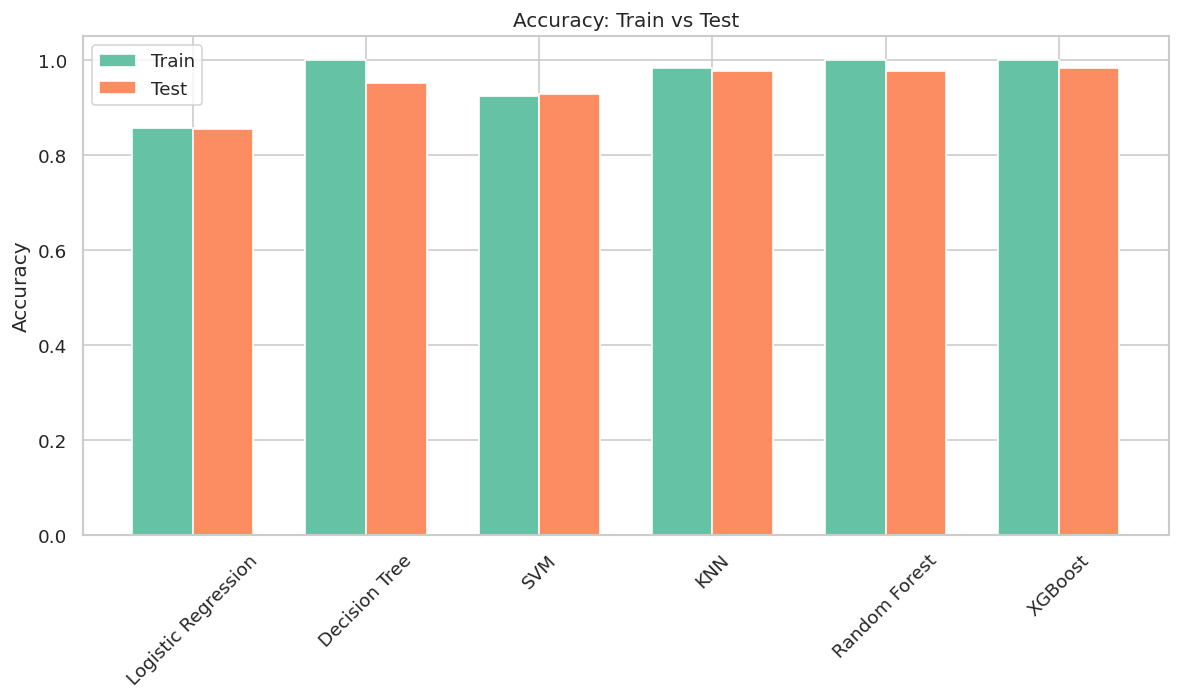

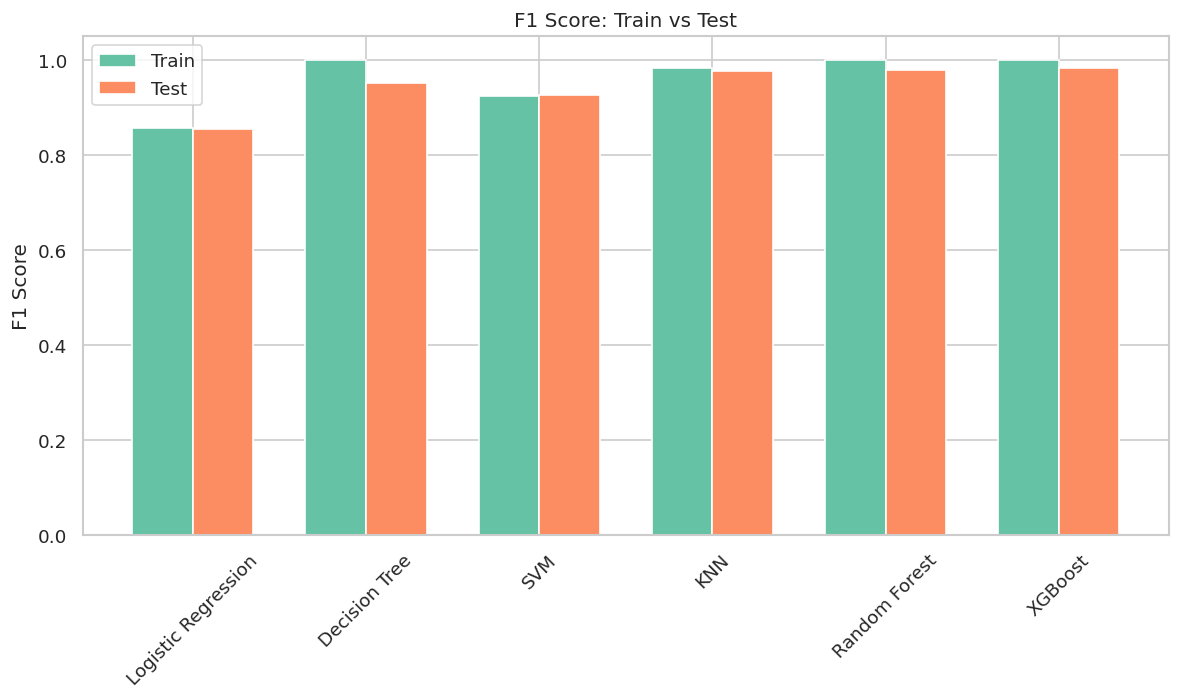

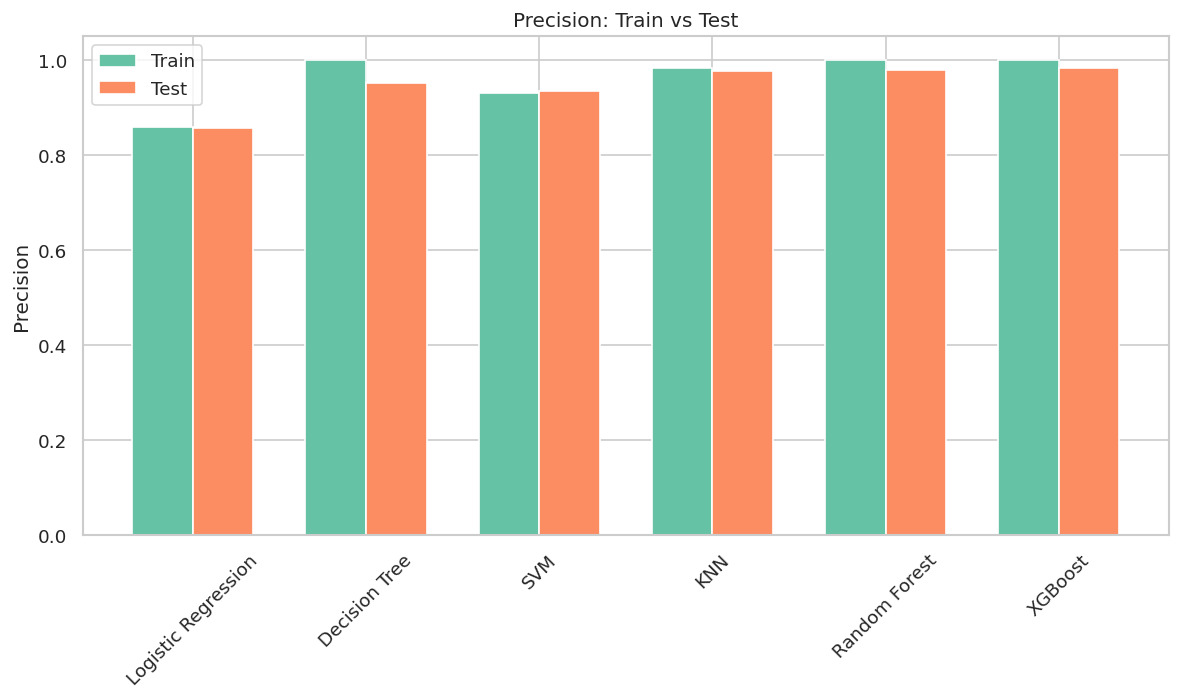

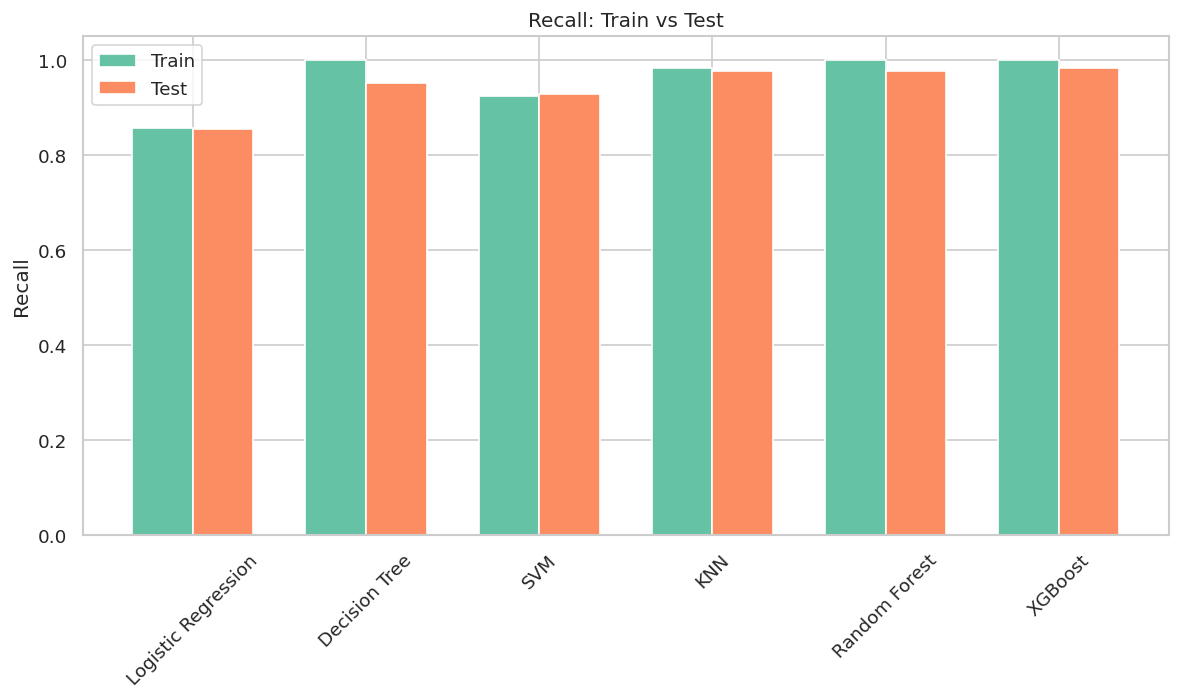

In [17]:
models = {
    "Logistic Regression": lr_model,
    "Decision Tree": dt_model,
    "SVM": svm_model,
    "KNN": knn_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
}

metrics = compute_metrics(models, X_train, X_test, y_train, y_test)
visualize_all_metrics(models, metrics)

**Dumbbell Plot (for Model Comparison)**

to compare training vs test accuracy for each model

In [18]:
def plot_dumbbell(metrics, metric_name="test_accuracy"):
    df = pd.DataFrame(metrics).T.reset_index()
    df.rename(columns={"index": "Model"}, inplace=True)


    plt.figure(figsize=(8, len(df)*0.6))
    for idx, row in df.iterrows():
        plt.plot([row[f"train_{metric_name}"], row[f"test_{metric_name}"]],
                 [idx, idx], color='gray', linewidth=2, zorder=1)


    plt.scatter(df[f"train_{metric_name}"], df.index, color='blue', s=100, label='Train', zorder=2)
    plt.scatter(df[f"test_{metric_name}"], df.index, color='red', s=100, label='Test', zorder=2)


    plt.yticks(df.index, df["Model"])
    plt.xlabel(metric_name.replace("_", " ").title())
    plt.title(f"Dumbbell Plot of {metric_name.replace('_', ' ').title()}")
    plt.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

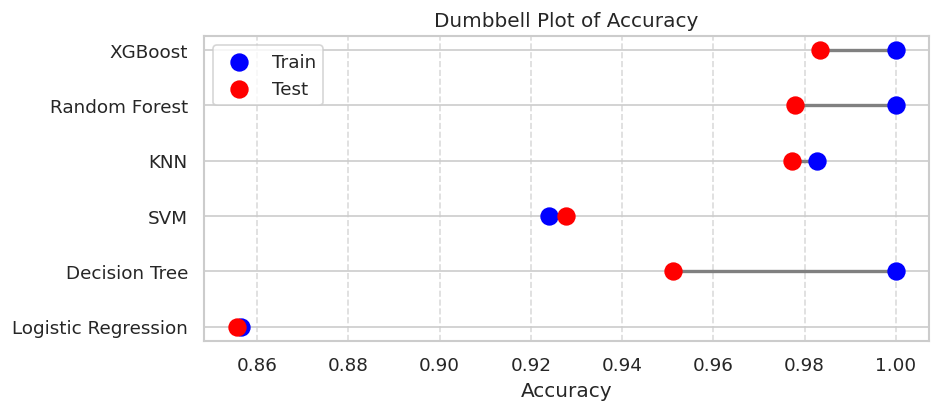

In [19]:
plot_dumbbell(metrics, metric_name="accuracy")

In [20]:
# Save XGBoost Model
joblib.dump(xgb_model, "xgb_model.pkl")

['xgb_model.pkl']

# **Grid search**

In [21]:
# SVM

from sklearn.model_selection import GridSearchCV
svm_parameters = {'kernel': ['rbf'],
                  'C': [100],
                  'gamma': [0.01, 0.1]
                }

svm = SVC(class_weight ='balanced')
svm_gs = GridSearchCV(estimator = svm, param_grid = svm_parameters)

svm_winner =svm_gs.fit(X_train, y_train)
svm_winner.score(X_test, y_test)

0.9894839337877313

In [22]:
# Train Support Vector Machine model with the best hyperparameters

svm_final =SVC(C=100, class_weight='balanced', gamma = 0.1).fit(X_train, y_train)
svm_final_model_score=svm_final.score(X_test, y_test)
svm_final_model_ypred=svm_final.predict(X_test)

print("SVM accuracy : ", svm_final_model_score )
print("SVM f1 score : ", f1_score(y_test, svm_final_model_ypred, average = "weighted") )
print("SVM recall score : ", recall_score(y_test, svm_final_model_ypred , average = "weighted") )
print("SVM precision score :", precision_score(y_test, svm_final_model_ypred , average = "weighted") )

SVM accuracy :  0.9894839337877313
SVM f1 score :  0.9894959921809914
SVM recall score :  0.9894839337877313
SVM precision score : 0.9895356206914374


In [23]:
metrics_before = {
    "train_accuracy": accuracy_score(y_train, svm_model.predict(X_train)),
    "test_accuracy": accuracy_score(y_test, svm_model_ypred),
    "train_f1": f1_score(y_train, svm_model.predict(X_train), average='weighted'),
    "test_f1": f1_score(y_test, svm_model_ypred, average='weighted'),
    "train_precision": precision_score(y_train, svm_model.predict(X_train), average='weighted'),
    "test_precision": precision_score(y_test, svm_model_ypred, average='weighted'),
    "train_recall": recall_score(y_train, svm_model.predict(X_train), average='weighted'),
    "test_recall": recall_score(y_test, svm_model_ypred, average='weighted')
}


metrics_after = {
    "train_accuracy": accuracy_score(y_train, svm_final.predict(X_train)),
    "test_accuracy": accuracy_score(y_test, svm_final_model_ypred),
    "train_f1": f1_score(y_train, svm_final.predict(X_train), average='weighted'),
    "test_f1": f1_score(y_test, svm_final_model_ypred, average='weighted'),
    "train_precision": precision_score(y_train, svm_final.predict(X_train), average='weighted'),
    "test_precision": precision_score(y_test, svm_final_model_ypred, average='weighted'),
    "train_recall": recall_score(y_train, svm_final.predict(X_train), average='weighted'),
    "test_recall": recall_score(y_test, svm_final_model_ypred, average='weighted')
}


df_comparison = pd.DataFrame([metrics_before, metrics_after], index=['Before Grid Search', 'After Grid Search'])
df_comparison = df_comparison.round(4)

In [24]:
# SVM Metrics Before & After Grid Search
df_comparison

,train_accuracy,test_accuracy,train_f1,test_f1,train_precision,test_precision,train_recall,test_recall
Before Grid Search,0.9241,0.9278,0.9237,0.9271,0.9300,0.9343,0.9241,0.9278
After Grid Search,0.9941,0.9895,0.9941,0.9895,0.9941,0.9895,0.9941,0.9895


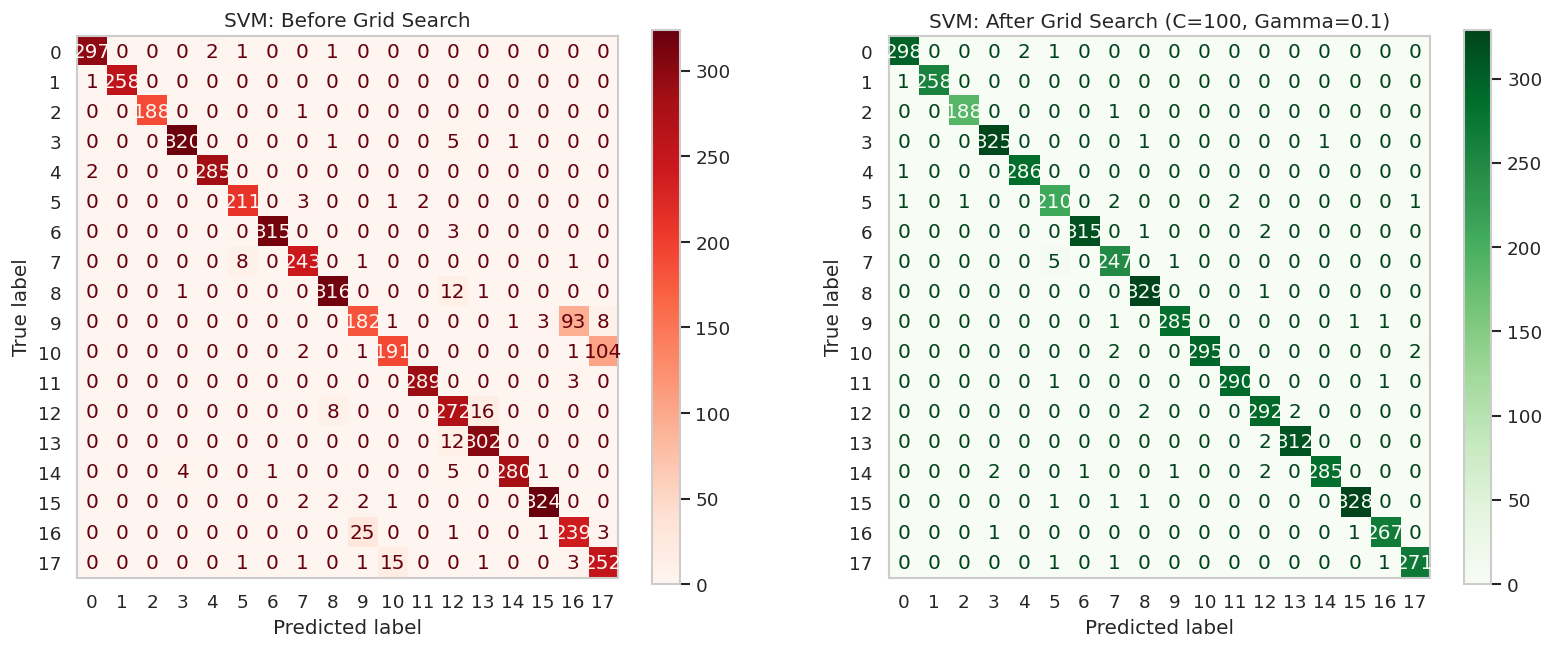

In [25]:
cm_base = confusion_matrix(y_test, svm_model_ypred)
svm_winner_ypred = svm_winner.predict(X_test)
cm_optimized = confusion_matrix(y_test, svm_winner_ypred)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_base)
disp1.plot(ax=ax1, cmap='Reds', values_format='d')
ax1.set_title('SVM: Before Grid Search')
ax1.grid(False)

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_optimized)
disp2.plot(ax=ax2, cmap='Greens', values_format='d')
ax2.set_title('SVM: After Grid Search (C=100, Gamma=0.1)')
ax2.grid(False)

plt.show()

# **Models Performance Evaluation Report**

### **1. Overview**

The goal of this project was to evaluate multiple classification models on the dataset and select the best-performing model based on key evaluation metrics: Accuracy, F1-Score, Precision and Recall.

**The models evaluated include:**

XGBoost

Random Forest

K-Nearest Neighbors (KNN)

Decision Tree

Support Vector Machine (SVM)

Logistic Regression



### **2. Model Performance Before SVM Grid Search**

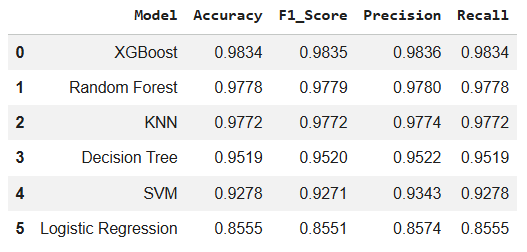

XGBoost achieved the highest baseline performance across all metrics before tuning followed closely by Random Forest and KNN

SVM and Logistic Regression lagged behind in terms of accuracy and F1-score suggesting suboptimal hyperparameters

Decision Tree showed reasonable performance but is prone to overfitting in raw form

### **3. SVM Performance After Grid Search**

After performing Grid Search hyperparameter tuning for SVM (optimizing C, gamma and kernel) the performance improved significantly:

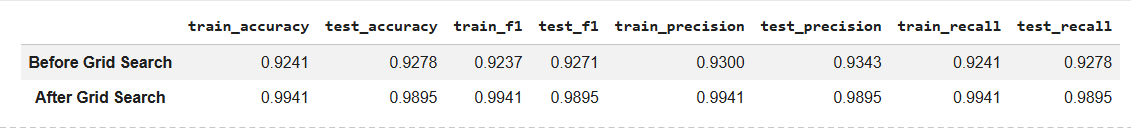



Hyperparameter tuning dramatically improved SVM performance surpassing all other models including XGBoost

The high F1-score indicates a strong balance between Precision and Recall which is critical for most classification tasks

Grid Search enabled the SVM to better handle the underlying data distribution by selecting the optimal regularization (C=100) and kernel parameters (gamma=0.1)

### **4. Model Selection**

SVM after Grid Search is the primary recommendation for production deployment as it provides the highest accuracy and F1-score indicating robust generalization and balanced performance

XGBoost could be considered as a secondary model if training time or interpretability is a priority as it performs well without extensive tuning

In [26]:
# Save SVM_Winner Model
joblib.dump(svm_winner,"svm_winner.pkl")

['svm_winner.pkl']